In [29]:
%matplotlib inline
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.distributions as tdist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML
import time
from PIL import Image
import torch.nn.functional as F

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [30]:
# Root directory for dataset
dataroot = "TestImages"#"StopSignImages"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32#64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
print ('...')

...


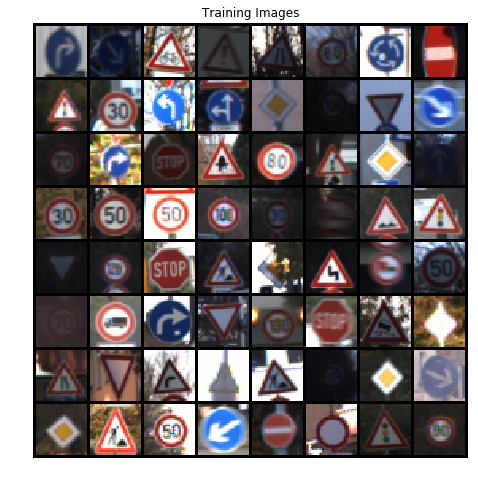

In [10]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
print ('...')

...


In [12]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init)
#To restore:
netG.load_state_dict(torch.load('./netG.pth'))
netG.eval()

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netD.apply(weights_init)
#To restore:
netD.load_state_dict(torch.load('./netD.pth'))
netD.eval()
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [16]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(image_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
print ("...")

...


In [10]:
# Training Loop
start_time = time.time()


# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
labelDist2 = tdist.Normal(torch.tensor([1.0]), torch.tensor([0.1]))
labelDist1 = tdist.Normal(torch.tensor([0.1]), torch.tensor([0.1]))

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):        
        random.seed(a=None, version=2)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = labelDist1.sample((b_size,))   #torch.full((b_size,), real_label, device=device)
#         idx = random.sample(range(0, b_size), 5)
#         for i in idx:
#             label[i] = 0
            
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label = labelDist2.sample((b_size,)) #torch.FloatTensor(b_size, ).uniform_(0.0, 0.1) 
#         idx = random.sample(range(0, b_size), 5)
#         for i in idx:
#             label[i] = 1
            
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = labelDist1.sample((b_size,)) # label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats                    
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        #save some output of generator
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
#             plt.figure(figsize=(15,15))
#             plt.imshow(np.transpose(img_list[-1], (1,2,0)))
#             plt.show()
        iters += 1

    print("--- %s seconds ---" % (time.time() - start_time))
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([86, 1])) that is different to the input size (torch.Size([86])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


--- 151.07895922660828 seconds ---
[1/1][99/99]	Loss_D: 1.1811	Loss_G: 1.8156	D(x): 0.4083	D(G(z)): 0.6512 / 0.8286


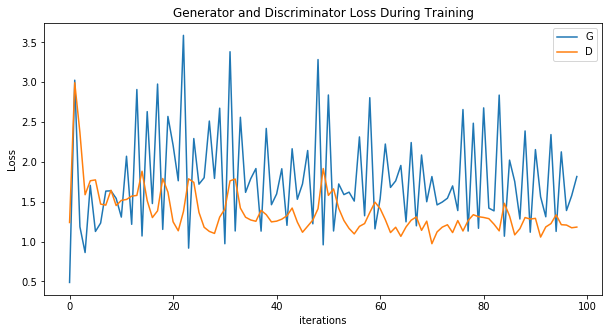

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

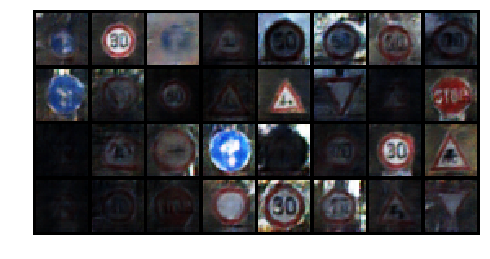

In [15]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

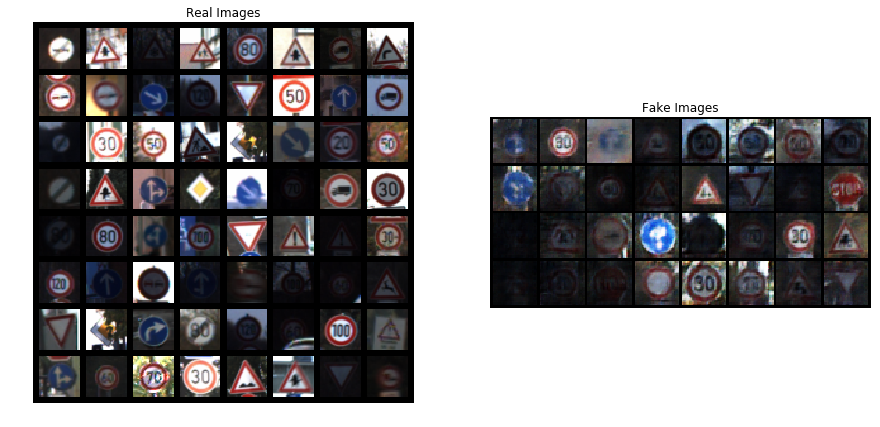

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

In [39]:
#train traffic sign classifier 
classes = set()
for i in range(43):
    classes.add(i)

classes = tuple(classes)

trainingClassifierRoot = 'TrainImageGrouped_resized'
testClassifierRoot = 'TestImages'

# Create the dataset
trainClassifierDataset = dset.ImageFolder(root=trainingClassifierRoot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

testClassifierDataset = dset.ImageFolder(root=testClassifierRoot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
trainClassifierLoader = torch.utils.data.DataLoader(trainClassifierDataset, batch_size=batch_size, shuffle=True, num_workers=workers)
testClassifierLoader = torch.utils.data.DataLoader(testClassifierDataset, batch_size=batch_size, shuffle=True, num_workers=workers)


In [59]:
class TrafficSignClassifier(nn.Module):
    def __init__(self, ngpu):
        super(TrafficSignClassifier, self).__init__()
        self.ngpu = ngpu
#         self.main = nn.Sequential(
#             nn.Conv2d(3, 12, 3, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(12, 12, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2), 
#             nn.Conv2d(12, 24, 3, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(24, 24, 3, 1, 1),
#             nn.ReLU(),
#             nn.Linear(16*16*24, 43)
#             )
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.fc = nn.Linear(in_features=16 * 16 * 24, out_features=43)
        
    
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.pool(output)

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.conv4(output)
        output = self.relu4(output)

        output = output.view(-1, 16 * 16 * 24)

        output = self.fc(output)

        return output
    
    

classfier = TrafficSignClassifier(ngpu).to(device)
print (classfier)
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

TrafficSignClassifier(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (fc): Linear(in_features=6144, out_features=43, bias=True)
)


In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classfier.parameters(), lr=0.001, momentum=0.9)

In [61]:
# Training Loop
start_time = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainClassifierLoader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classfier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testClassifierLoader:
            images, labels = data
            outputs = classfier(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Epoch %d: Accuracy of the network on the 10000 test images: %d %%' % (epoch, 100 * correct / total))
    print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')

Epoch 0: Accuracy of the network on the 10000 test images: 3 %


Process Process-60:
Process Process-59:
Process Process-57:
Process Process-58:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  Fi

KeyboardInterrupt: 

In [41]:
correct = 0
total = 0
with torch.no_grad():
    for data in testClassifierLoader:
        images, labels = data
        outputs = classfier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 2 %


torch.Size([3, 32, 32])


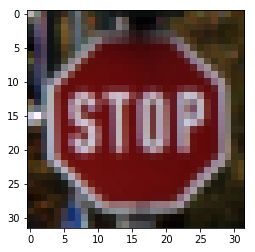

In [40]:
##image inpainting
maskedImageRoot = "singleImg"
# We can use an image folder dataset the way we have it setup.
# Create the dataset
maskedDataset = dset.ImageFolder(root=trainClassifierLoader,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
maskedImgLoader = torch.utils.data.DataLoader(maskedDataset, batch_size=batch_size, shuffle=True, num_workers=workers)
maskedBatch = next(iter(maskedImgLoader))
realImg = maskedBatch[0].to(device)[0] #3*32*32

mask = torch.ones(size=testImage.shape).to(device)
mask[:,10:20, 5:15] = 0.0
print (mask.shape)
testImage = torch.mul(realImg, mask)  

vutils.save_image(realImg, 'testImage.png', normalize=True)
img=mpimg.imread('testImage.png')
plt.imshow(img)
plt.show()

iteration: 0
total loss, context loss, percept loss:  tensor(599.3951, grad_fn=<ThAddBackward>) tensor(599.3808, grad_fn=<NormBackward0>) tensor(0.1428, grad_fn=<BinaryCrossEntropyBackward>)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


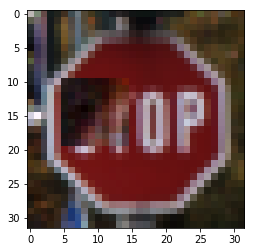

iteration: 100
total loss, context loss, percept loss:  tensor(389.5961, grad_fn=<ThAddBackward>) tensor(389.5855, grad_fn=<NormBackward0>) tensor(0.1059, grad_fn=<BinaryCrossEntropyBackward>)


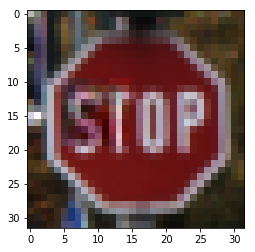

iteration: 200
total loss, context loss, percept loss:  tensor(340.2456, grad_fn=<ThAddBackward>) tensor(340.2333, grad_fn=<NormBackward0>) tensor(0.1236, grad_fn=<BinaryCrossEntropyBackward>)


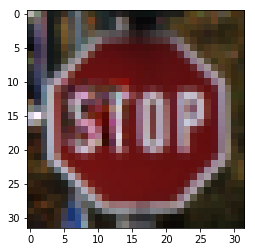

iteration: 300
total loss, context loss, percept loss:  tensor(320.3518, grad_fn=<ThAddBackward>) tensor(320.3403, grad_fn=<NormBackward0>) tensor(0.1154, grad_fn=<BinaryCrossEntropyBackward>)


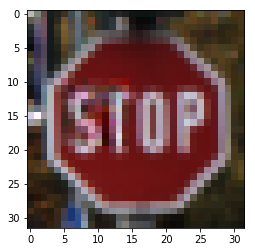

iteration: 400
total loss, context loss, percept loss:  tensor(306.0093, grad_fn=<ThAddBackward>) tensor(305.9996, grad_fn=<NormBackward0>) tensor(0.0971, grad_fn=<BinaryCrossEntropyBackward>)


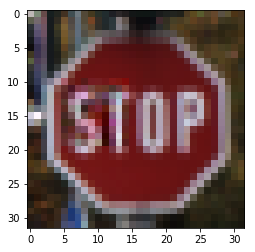

iteration: 500
total loss, context loss, percept loss:  tensor(296.9436, grad_fn=<ThAddBackward>) tensor(296.9348, grad_fn=<NormBackward0>) tensor(0.0879, grad_fn=<BinaryCrossEntropyBackward>)


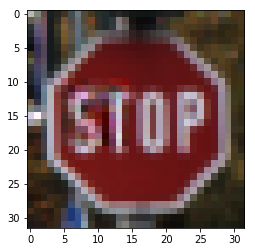

iteration: 600
total loss, context loss, percept loss:  tensor(290.1620, grad_fn=<ThAddBackward>) tensor(290.1536, grad_fn=<NormBackward0>) tensor(0.0847, grad_fn=<BinaryCrossEntropyBackward>)


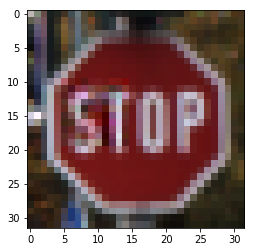

iteration: 700
total loss, context loss, percept loss:  tensor(285.9682, grad_fn=<ThAddBackward>) tensor(285.9596, grad_fn=<NormBackward0>) tensor(0.0864, grad_fn=<BinaryCrossEntropyBackward>)


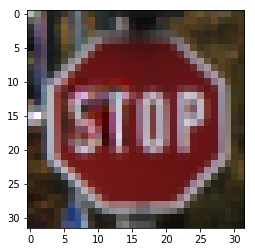

iteration: 800
total loss, context loss, percept loss:  tensor(283.0485, grad_fn=<ThAddBackward>) tensor(283.0397, grad_fn=<NormBackward0>) tensor(0.0885, grad_fn=<BinaryCrossEntropyBackward>)


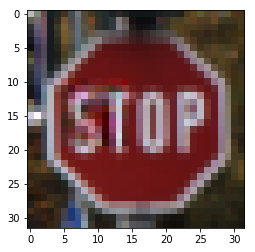

iteration: 900
total loss, context loss, percept loss:  tensor(280.2964, grad_fn=<ThAddBackward>) tensor(280.2874, grad_fn=<NormBackward0>) tensor(0.0900, grad_fn=<BinaryCrossEntropyBackward>)


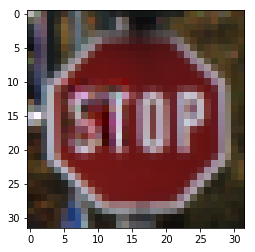

iteration: 1000
total loss, context loss, percept loss:  tensor(277.4436, grad_fn=<ThAddBackward>) tensor(277.4346, grad_fn=<NormBackward0>) tensor(0.0902, grad_fn=<BinaryCrossEntropyBackward>)


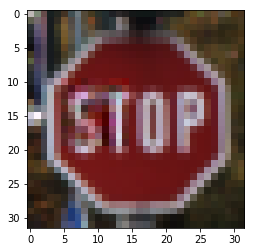

iteration: 1100
total loss, context loss, percept loss:  tensor(275.0065, grad_fn=<ThAddBackward>) tensor(274.9977, grad_fn=<NormBackward0>) tensor(0.0882, grad_fn=<BinaryCrossEntropyBackward>)


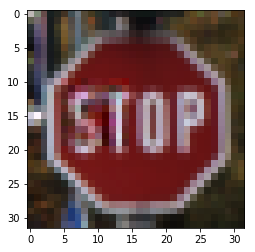

iteration: 1200
total loss, context loss, percept loss:  tensor(272.6212, grad_fn=<ThAddBackward>) tensor(272.6127, grad_fn=<NormBackward0>) tensor(0.0857, grad_fn=<BinaryCrossEntropyBackward>)


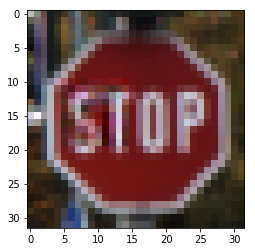

iteration: 1300
total loss, context loss, percept loss:  tensor(270.6444, grad_fn=<ThAddBackward>) tensor(270.6360, grad_fn=<NormBackward0>) tensor(0.0839, grad_fn=<BinaryCrossEntropyBackward>)


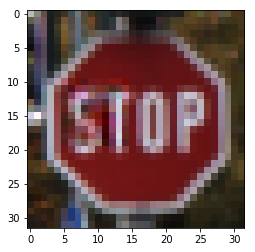

iteration: 1400
total loss, context loss, percept loss:  tensor(269.1662, grad_fn=<ThAddBackward>) tensor(269.1577, grad_fn=<NormBackward0>) tensor(0.0850, grad_fn=<BinaryCrossEntropyBackward>)


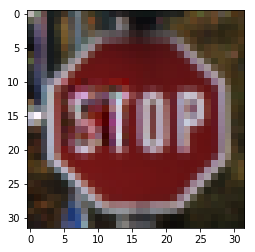

iteration: 1500
total loss, context loss, percept loss:  tensor(267.9672, grad_fn=<ThAddBackward>) tensor(267.9587, grad_fn=<NormBackward0>) tensor(0.0853, grad_fn=<BinaryCrossEntropyBackward>)


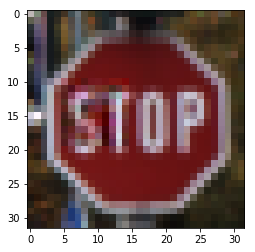

iteration: 1600
total loss, context loss, percept loss:  tensor(266.9955, grad_fn=<ThAddBackward>) tensor(266.9869, grad_fn=<NormBackward0>) tensor(0.0859, grad_fn=<BinaryCrossEntropyBackward>)


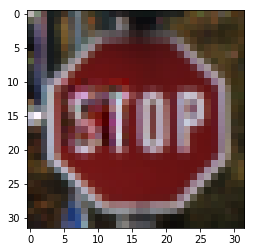

iteration: 1700
total loss, context loss, percept loss:  tensor(265.6734, grad_fn=<ThAddBackward>) tensor(265.6648, grad_fn=<NormBackward0>) tensor(0.0856, grad_fn=<BinaryCrossEntropyBackward>)


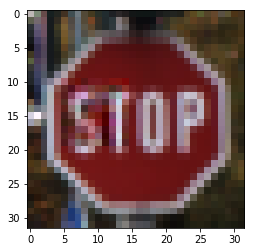

iteration: 1800
total loss, context loss, percept loss:  tensor(264.5571, grad_fn=<ThAddBackward>) tensor(264.5482, grad_fn=<NormBackward0>) tensor(0.0898, grad_fn=<BinaryCrossEntropyBackward>)


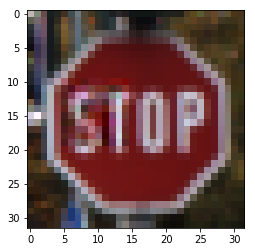

iteration: 1900
total loss, context loss, percept loss:  tensor(263.7680, grad_fn=<ThAddBackward>) tensor(263.7583, grad_fn=<NormBackward0>) tensor(0.0966, grad_fn=<BinaryCrossEntropyBackward>)


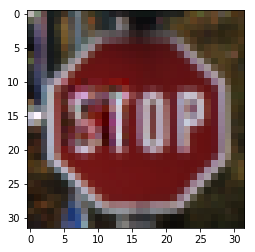

In [43]:
lambd = 0.1
inpaintCriteria = nn.BCELoss()
for i, data in enumerate(maskedImgLoader, 0): 
    realImg = data[0].to(device)[0]
    mask = torch.ones(size=testImage.shape).to(device)
    mask[:,10:20, 5:15] = 0.0
    croppedImg = torch.mul(realImg, mask)  
        
    #z = torch.randn(1, nz, 1, 1, device=device)
    z = torch.rand(size=[1,100,1,1],dtype=torch.float32,requires_grad=True,device=device)
    z.data.mul_(2.0).sub_(1.0)
    opt = optim.Adam([z],lr=0.005) 
    for i in range(1000):
        if z.grad is not None:
            z.grad.data.zero_()
        netG.zero_grad()
        netD.zero_grad()
        
        fake = netG(z)
        fakeMasked = torch.mul(fake[0], mask)
        impaintedImg = torch.mul(fake,(1-mask)) + croppedImg   

         
        contextLoss = torch.norm((croppedImg-fakeMasked),p=1)
        discOutput = netD(impaintedImg)
        batchLabels = torch.full((1,), 1, device=device)
        perceptLoss = inpaintCriteria(discOutput, batchLabels)

        totalLoss = contextLoss + lambd*perceptLoss
        if i % 100==0:
            print("iteration:" , i)
            print ("total loss, context loss, percept loss: ", totalLoss, contextLoss, perceptLoss)
            vutils.save_image(impaintedImg, 'impaintImage.png', normalize=True)
            img=mpimg.imread('impaintImage.png')
            plt.imshow(img)
            plt.show()
        totalLoss.backward()
        #print(z.grad)
        opt.step()

In [ ]:
def image_pixel_removing(losing_percent,image_path,filename):
    im=Image.open(image_path)
    pix = im.load()
    width=im.size[0]
    height=im.size[1]
    x_center=width/2
    y_center=height/2
    x_off=width*losing_percent/2
    y_off=height*losing_percent/2
    global flag
    if flag:
        print('width',width)
        print('height',height)
        print('x:',int(x_center-x_off),int(x_center+x_off))
        print('y:',int(y_center-y_off),int(y_center+y_off))
        flag=0
    for x in range(int(x_center-x_off),int(x_center+x_off)):
        for y in range(int(y_center-y_off),int(y_center+y_off)):
            pix[x,y]=(0,0,0)
    im.save('/Users/wujiaying/Downloads/ECE544_final_project_GAN/AllTrafficImageModified/'+filename)

In [ ]:
directory='/Users/wujiaying/Downloads/ECE544_final_project_GAN/AllTrafficImage'
global flag
flag=1
for filename in os.listdir(directory):
    if filename.endswith(".png"): 
        path=os.path.join(directory, filename)
        image_pixel_removing(0.3,path,filename)
        #print()
        #print(filename)
        continue
    else:
        continue